cost:  31.06
cost:  6.3355
cost:  2.5905
cost:  1.753
cost:  1.2022
cost:  0.9145
cost:  0.2151
cost:  0.3343
cost:  1.7464
cost:  0.2562


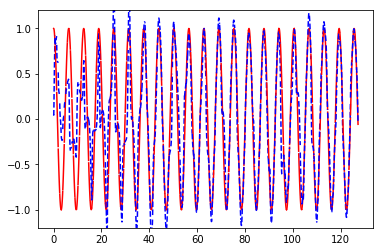

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 10
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    # returned seq, res and xs: shape (batch, step, input)
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]


class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    def add_input_layer(self,):
        # TODO: add_input_layer function

    def add_cell(self):
        # TODO: add_cell function

    def add_output_layer(self):
        # TODO: add_output_layer function

    def compute_cost(self):
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function=self.ms_error,
            name='losses'
        )
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name='losses_sum'),
                self.batch_size,
                name='average_cost')
            tf.summary.scalar('cost', self.cost)

    def ms_error(self, y_pre, y_target):
        return tf.square(tf.subtract(y_pre, y_target))

    def _weight_variable(self, shape, name='weights'):
        initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)


if __name__ == '__main__':
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess = tf.Session()
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    init = tf.global_variables_initializer()
    sess.run(init)
    # relocate to the local dir and run this line to view it on Chrome (http://0.0.0.0:6006/):
    # $ tensorboard --logdir='logs'

    plt.ion()
    plt.show()
    for i in range(200):
        seq, res, xs = get_batch()
        if i == 0:
            feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    # create initial state
            }
        else:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state    # use last state as the initial state for this run
            }

        _, cost, state, pred = sess.run(
            [model.train_op, model.cost, model.cell_final_state, model.pred],
            feed_dict=feed_dict)

        # plotting
        plt.plot(xs[0, :], res[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
        plt.ylim((-1.2, 1.2))
        plt.draw()
        plt.pause(0.3)

        if i % 20 == 0:
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)